In [1]:
import os

import cv2
import numpy as np
import pandas as pd
from torch.utils.data import Dataset

from segmentation_baseline.utils import *

/home/user/Projects/segmentation_baseline/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Image size: 1280x1280 | step_x: 128 | step_y: 128
Patches per image: 81


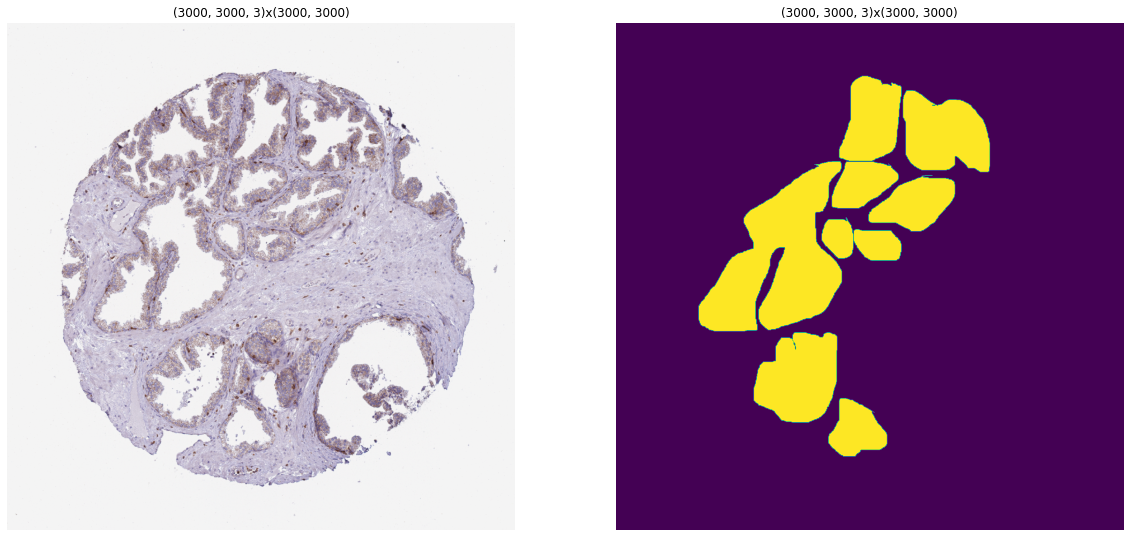

In [43]:
class PatchTrainBinaryDataset(Dataset):
    def __init__(self, 
                 csv_path, 
                 images_folder, 
                 masks_folder, 
                 patch_h, 
                 patch_w, 
                 img_h, 
                 img_w, 
                 step_y, 
                 step_x, 
                 labels=None,
                 augmentations=None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.augmentations = augmentations
        self.patch_h = patch_h
        self.patch_w = patch_w
        self.img_h = img_h
        self.img_w = img_w
        self.step_x = step_x
        self.step_y = step_y
        self.labels = labels if labels else [0, 1]

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        info = self.df.iloc[index]
        img_name = '{}.tiff'.format(info['id'])
        img_path = os.path.join(self.images_folder, img_name)
        msk_path = os.path.join(self.masks_folder, img_name)
        
        image = cv2.imread(img_path)
        mask = cv2.imread(msk_path, 0)
        
        orig_h, orig_w = image.shape[:2]
        
        if self.augmentations is not None:
            item = self.augmentations(image=image, mask=mask)
            image = item['image']
            mask = item['mask']
        
        image = resize_if_need(image, self.img_h, self.img_w)
        mask = resize_if_need(mask, self.img_h, self.img_w)
        res_h, res_w = image.shape[:2]
        
        image = make_img_padding(image, self.img_h, self.img_w)
        mask = make_img_padding(mask[:, :, None], self.img_h, self.img_w)[:, :, 0]
        
        img_patches = split_on_patches(
            image, 
            self.patch_h, 
            self.patch_w,
            step_x=self.step_x,
            step_y=self.step_y,
        )
            
        msk_patches = split_on_patches(
            mask, 
            self.patch_h, 
            self.patch_w,
            step_x=self.step_x,
            step_y=self.step_y,
        )
        
        img_patches = [preprocess_image(img_patch) for img_patch in img_patches]
        msk_patches = [preprocess_single_mask(g_item, labels=self.labels).unsqueeze(0) for g_item in msk_patches]
        
        img_patches = torch.stack(img_patches)
        msk_patches = torch.stack(msk_patches)
        
        return {
            'img_patches': img_patches, 
            'msk_patches': msk_patches, 
            'orig_h': orig_h,
            'orig_w': orig_w,
            'res_h': res_h,
            'res_w': res_w,
        }


images_dir = '/home/user/datasets/hubmap-organ-segmentation/train_images'
masks_dir = '/home/user/datasets/hubmap-organ-segmentation/train_masks'
csv_path = '/home/user/datasets/hubmap-organ-segmentation/train_split.csv'

patch_w = 256
patch_h = 256

img_w = patch_w*5
img_h = patch_h*5

step_x = patch_w // 2
step_y = patch_h // 2

count = 0
for _ in range(0, img_h - (patch_h - step_y), step_y):
    for _ in range(0, img_w - (patch_w - step_x), step_x):
        count += 1

print(f'Image size: {img_h}x{img_w} | step_x: {step_x} | step_y: {step_y}')
print(f'Patches per image: {count}')

train_dataset = PatchTrainBinaryDataset(csv_path, images_dir, masks_dir, patch_h, patch_w, img_h, img_w, step_y, step_x)
item = train_dataset[0]
orig_h, orig_w = item['orig_h'], item['orig_w']

img = glue_image_patches(
    [process_img2np(x) for x in item['img_patches']], 
    patch_h, 
    patch_w,
    img_h, 
    img_w,
    img_c=3,
    step_x=step_x,
    step_y=step_y,
)[:orig_h, :orig_w]

msk = glue_mask_patches(
    [x.cpu().permute(1, 2, 0).numpy().astype(np.uint8) for x in item['msk_patches']], 
    patch_h, 
    patch_w,
    img_h, 
    img_w,
    img_c=1,
    step_x=step_x,
    step_y=step_y,
)[:orig_h, :orig_w]

img = cv2.resize(img, (item['orig_w'], item['orig_h']), interpolation=cv2.INTER_NEAREST)
msk = cv2.resize(msk, (item['orig_w'], item['orig_h']), interpolation=cv2.INTER_NEAREST)

show_images([img, msk*10], title=f'{img.shape}x{msk.shape}', figsize=(20, 30))

In [29]:
torch.stack(item['img_patches']).shape, torch.stack(item['msk_patches']).shape

(torch.Size([81, 3, 256, 256]), torch.Size([81, 1, 256, 256]))

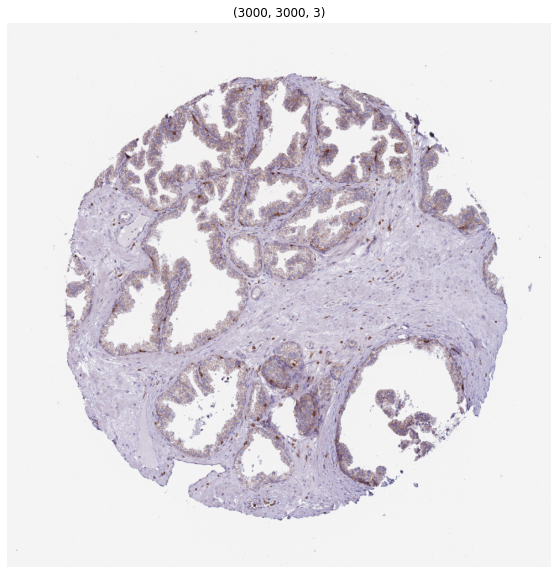

In [42]:
class PatchTestBinaryDataset(Dataset):
    def __init__(self, 
                 csv_path, 
                 images_folder, 
                 patch_h, 
                 patch_w, 
                 img_h, 
                 img_w, 
                 step_y,
                 step_x, 
                 augmentations=None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.augmentations = augmentations
        self.patch_h = patch_h
        self.patch_w = patch_w
        self.img_h = img_h
        self.img_w = img_w
        self.step_x = step_x
        self.step_y = step_y

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        info = self.df.iloc[index]
        img_name = '{}.tiff'.format(info['id'])
        img_path = os.path.join(self.images_folder, img_name)
        
        image = cv2.imread(img_path)
        orig_h, orig_w = image.shape[:2]
        
        if self.augmentations is not None:
            item = self.augmentations(image=image)
            image = item['image']
        
        image = resize_if_need(image, self.img_h, self.img_w)
        res_h, res_w = image.shape[:2]
        
        image = make_img_padding(image, self.img_h, self.img_w)
        
        img_patches = split_on_patches(
            image, 
            patch_h, 
            patch_w,
            step_x=step_x,
            step_y=step_y,
        )
        
        img_patches = [preprocess_image(img_patch) for img_patch in img_patches]
        img_patches = torch.stack(img_patches)
        
        return {
            'img_patches': img_patches,
            'image_name': img_name,
            'orig_h': orig_h,
            'orig_w': orig_w,
            'res_h': res_h,
            'res_w': res_w,
        }
    
test_dataset = PatchTestBinaryDataset(csv_path, images_dir, patch_h, patch_w, img_h, img_w, step_y, step_x)
item = test_dataset[0]
orig_h, orig_w = item['orig_h'], item['orig_w']

img = glue_image_patches(
    [process_img2np(x) for x in item['img_patches']], 
    patch_h, 
    patch_w,
    img_h, 
    img_w,
    img_c=3,
    step_x=step_x,
    step_y=step_y,
)[:orig_h, :orig_w]

img = cv2.resize(img, (item['orig_w'], item['orig_h']), interpolation=cv2.INTER_NEAREST)
show_image(img, title=f'{img.shape}', figsize=(10, 10))

Image size: 1024x1024 | step_x: 128 | step_y: 128
Patches per image: 49


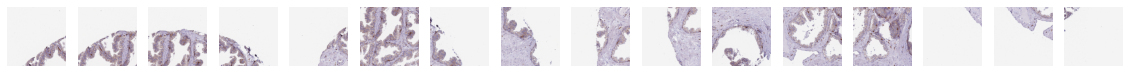

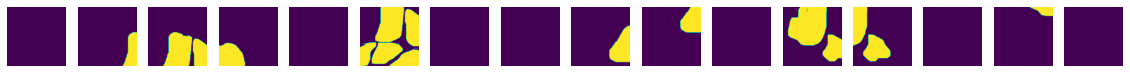

In [66]:
class PatchTrainBinaryDataset(Dataset):
    def __init__(self, 
                 csv_path, 
                 images_folder, 
                 masks_folder, 
                 patch_h, 
                 patch_w, 
                 img_h, 
                 img_w, 
                 step_y, 
                 step_x, 
                 batch_size=None,
                 labels=None,
                 augmentations=None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.augmentations = augmentations
        self.patch_h = patch_h
        self.patch_w = patch_w
        self.img_h = img_h
        self.img_w = img_w
        self.step_x = step_x
        self.step_y = step_y
        self.batch_size = batch_size
        self.labels = labels if labels else [0, 1]

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        info = self.df.iloc[index]
        img_name = '{}.tiff'.format(info['id'])
        img_path = os.path.join(self.images_folder, img_name)
        msk_path = os.path.join(self.masks_folder, img_name)
        
        image = cv2.imread(img_path)
        mask = cv2.imread(msk_path, 0)
        
        orig_h, orig_w = image.shape[:2]
        
        if self.augmentations is not None:
            item = self.augmentations(image=image, mask=mask)
            image = item['image']
            mask = item['mask']
        
        image = resize_if_need(image, self.img_h, self.img_w)
        mask = resize_if_need(mask, self.img_h, self.img_w)
        res_h, res_w = image.shape[:2]
        
        image = make_img_padding(image, self.img_h, self.img_w)
        mask = make_img_padding(mask[:, :, None], self.img_h, self.img_w)[:, :, 0]
        
        img_patches = split_on_patches(
            image, 
            self.patch_h, 
            self.patch_w,
            step_x=self.step_x,
            step_y=self.step_y,
        )
            
        msk_patches = split_on_patches(
            mask, 
            self.patch_h, 
            self.patch_w,
            step_x=self.step_x,
            step_y=self.step_y,
        )
        
        img_patches = [preprocess_image(img_patch) for img_patch in img_patches]
        msk_patches = [preprocess_single_mask(g_item, labels=self.labels).unsqueeze(0) for g_item in msk_patches]
        
        patch_count = len(img_patches)
        indexes = np.zeros(patch_count, dtype=int)
        indexes[:self.batch_size] = 1
        np.random.shuffle(indexes)
        indexes = indexes.astype(bool)
        
        img_patches = torch.stack(img_patches)[indexes]
        msk_patches = torch.stack(msk_patches)[indexes]
        
        return {
            'img_patches': img_patches, 
            'msk_patches': msk_patches, 
            'orig_h': orig_h,
            'orig_w': orig_w,
            'res_h': res_h,
            'res_w': res_w,
        }


images_dir = '/home/user/datasets/hubmap-organ-segmentation/train_images'
masks_dir = '/home/user/datasets/hubmap-organ-segmentation/train_masks'
csv_path = '/home/user/datasets/hubmap-organ-segmentation/train_split.csv'

batch_size = 16
patch_w = 256
patch_h = 256

img_w = patch_w*4
img_h = patch_h*4

step_x = patch_w // 2
step_y = patch_h // 2

count = 0
for _ in range(0, img_h - (patch_h - step_y), step_y):
    for _ in range(0, img_w - (patch_w - step_x), step_x):
        count += 1

print(f'Image size: {img_h}x{img_w} | step_x: {step_x} | step_y: {step_y}')
print(f'Patches per image: {count}')

train_dataset = PatchTrainBinaryDataset(
    csv_path, images_dir, masks_dir, 
    patch_h=patch_h, patch_w=patch_w, 
    img_h=img_h, img_w=img_w, 
    step_y=step_y, step_x=step_x, 
    batch_size=batch_size)

item = train_dataset[0]
orig_h, orig_w = item['orig_h'], item['orig_w']

imgs = [process_img2np(x) for x in item['img_patches']]
msks = [x.cpu().permute(1, 2, 0).numpy().astype(np.uint8) for x in item['msk_patches']]

show_images(imgs, figsize=(20, 30))
show_images(msks, figsize=(20, 30))

In [ ]:
# datasets:
#   train:
#     target: segmentation_baseline.datasets.PatchTrainBinaryDataset
#     params:
#       img_h: 1024
#       img_w: 1024
#       patch_h: 256
#       patch_w: 256
#       step_y: 128 
#       step_x: 128 
#       batch_size: 32
#       images_dir: /home/user/datasets/hubmap-organ-segmentation/train_images
#       masks_dir: /home/user/datasets/hubmap-organ-segmentation/train_masks
#       csv_path: /home/user/datasets/hubmap-organ-segmentation/train_split.csv
#   valid:
#     target: segmentation_baseline.datasets.PatchTrainBinaryDataset
#     params:
#       img_h: 1024
#       img_w: 1024
#       patch_h: 256
#       patch_w: 256
#       step_y: 128 
#       step_x: 128 
#       batch_size: 32
#       images_dir: /home/user/datasets/hubmap-organ-segmentation/train_images
#       masks_dir: /home/user/datasets/hubmap-organ-segmentation/train_masks
#       csv_path: /home/user/datasets/hubmap-organ-segmentation/valid_split.csv

In [67]:
768 / 256

3.0